In [2]:
from urllib2 import urlopen
from urllib2 import HTTPError
from bs4 import BeautifulSoup
import pandas as pd
import re

In [3]:
# Because of all different formats of wiki pages I choose to handle some formats each but not all.
# The coactors were indexed from the info block in the right handside of the movie page under the starring section
# The awards were the sum of the Won tags in the awards of the actor (if the was a page avlible)
# Actors how coactored with the selected actor will have multiple movie titles in table 2
# If information was not avlible I mentioned it in the table

In [4]:
def getFilmTable(url):
    try:
        html = urlopen(url)
    except HTTPError as e:
        print("err http")
        return e
    try:
        soup = BeautifulSoup(html,"lxml")
        return soup.find_all("table",class_="wikitable sortable")[0]
    except AttributeError as e:
        print("err atr")
        return e

In [5]:
wiki_url = "https://en.wikipedia.org"
film_table = getFilmTable(wiki_url + '/wiki/Ryan_Gosling')

In [6]:
Year=[]
Title=[]
Role=[]

header_row = True
for row in film_table.findAll("tr"):
    if not header_row:
        cells = row.findAll('td')
        index_of_title = 1
        if len(cells) == 3:
            index_of_title = 0
            last_inserted_year = Year[-1]
            Year.append(last_inserted_year)
        else:
            Year.append(cells[0].find(text=True))
        
        Title.append(cells[index_of_title])
        role = cells[index_of_title + 1].find(text=True)
        if role == None:
            Role.append(cells[index_of_title + 2].find(text=True))
        else:
            Role.append(role)
    header_row = False

In [7]:
df=pd.DataFrame(Year,columns=['Date'])
df['Title']=list(map(lambda title : title.find(text=True), Title))
df['Role']=Role
df

,Date,Title,Role
0,1997,Frankenstein and Me,Kenny
1,2000,Remember the Titans,Alan Bosley
2,2001,"Believer, The",Danny Balint
3,2002,Murder by Numbers,Richard Haywood
4,2002,"Slaughter Rule, The",Roy Chutney
5,2003,"United States of Leland, The",Leland P. Fitzgerald
6,2004,The Notebook,Noah Calhoun
7,2005,Stay,Henry Letham
8,2006,Half Nelson,Dan Dunne
9,2007,Fracture,Willy Beachum


In [24]:
films_with_coactor = []
coactor = []
coactor_href = []
year_of_birth = []
country = []
awards = []

In [25]:
def get_actor_awards_from_url(url):
    url = wiki_url + url
    try:
        html = urlopen(url)
    except HTTPError as e:
        print("err http")
        return e
    try:
        soup = BeautifulSoup(html,"lxml")
        number_of_awards = 0
        table = soup.find_all("table",class_ = 'infobox')
        try:
            def checker(yes):
                if yes.text == "Won":
                    return 1
                else:
                    return 0
            number_of_awards = reduce(lambda acc,yes: acc + checker(yes),[0] + soup.find_all(class_="yes"))
            if number_of_awards == 0:
                if(len(table[0].find_all('dt',text="Total Awards"))):
                    wins = int(table[0].find_all("td",class_="yes")[-1].text)
                    number_of_awards = wins
                else:
                    wins = table[0].find_all("td",class_="yes")
                    number_of_awards = reduce(lambda acc,td: int(td.text)+acc, [0] + wins)
        except:
            number_of_awards = "Format unexpected for hw1"
        return number_of_awards
    except AttributeError as e:
        print("err atr")
        return e

In [26]:
def get_actor_awards(actor_name):
    last_name = actor_name.split(" ")[-1]
    try:
        url = wiki_url+"/w/index.php?title=Category:Lists_of_awards_by_actor&from=" + last_name[0]
        html = urlopen(url)
    except HTTPError as e:
        print("err http")
        return e
    try:
        soup = BeautifulSoup(html,"lxml")
        number_of_awards = "Not avlible"
        link = soup.find_all("a",text=re.compile(r"(" + actor_name + r")"))
        if len(link) != 0:
            number_of_awards = get_actor_awards_from_url(link[0]['href'])
        return number_of_awards
    except AttributeError as e:
        print("err atr")
        return e


In [27]:
def get_actor_info(url):
    try:
        html = urlopen(url)
    except HTTPError as e:
        print("err http")
        return e
    try:
        soup = BeautifulSoup(html,"lxml")
        name = soup.find("h1",id="firstHeading").find(text=True)
        try:
            actor_info = filter(lambda table : len(table.find_all('th',text="Born")),soup.find_all('tr'))[0]
            year_of_birth = actor_info.find_all('span',class_='bday')[0].text[0:4]
            full_address =actor_info.find_all('span',class_='birthplace')[0].text
            country = full_address[full_address.rfind(",")+1:]
        except:
            try:
                year_text = soup.find_all(text=re.compile(r"\(([^(])*born([^)]+)\)"))[0]
                year_text = year_text[year_text.find(")")-4,year_text.find(")")]
                year_of_birth = year_text
            except:
                year_of_birth = "Not avlible"
            

            country = "Not avlible"
        number_of_awards = get_actor_awards(name)
        return name,year_of_birth,country,number_of_awards
    except AttributeError as e:
        print("err atr")
        return e

In [28]:
def get_film_and_cast_href(url):
    try:
        html = urlopen(url)
    except HTTPError as e:
        print("err http")
        return e
    try:
        soup = BeautifulSoup(html,"lxml")
        title = soup.find("h1",id="firstHeading").find_all('i')[0].find(text=True)
        try:
            cast_section = filter(lambda table : len(table.find_all('th',text="Starring")),soup.find_all('tr'))
            actors_with_href = filter(lambda actor_li : len(actor_li.find_all('a')) != 0 ,cast_section[0].find_all('li'))
            actors_hrefs_and_titles = map(lambda actor_li : (actor_li.text , actor_li.find_all('a')[0]['href'] ),actors_with_href)
            if len(actors_with_href) == 0:
                actors_with_href = filter(lambda actor_td : len(actor_td.find_all('a')) != 0 ,cast_section[0].find_all('td'))
                actors_hrefs_and_titles = map(lambda actor_a : (actor_a.text , actor_a['href'] ),actors_with_href[0].find_all('a'))

            actors_info_without_mined_actor = filter(lambda info : info[1].lower() != 'ryan gosling',actors_hrefs_and_titles)
            actors_hrefs = map(lambda info : 'https://en.wikipedia.org' + info[1],actors_info_without_mined_actor)
        except:
            actors_hrefs = []
        return actors_hrefs,title
    except AttributeError as e:
        print("err atr")
        return e

In [29]:
def compose_film_fection(url):
    
    cast_href , title = get_film_and_cast_href(url)
    for href in cast_href:
        try:
            index_of_actor = coactor_href.index(href)
        except ValueError as e:
            index_of_actor = -1
            
        if index_of_actor != -1:
            films_with_coactor[index_of_actor].append(title)
        else:
            name,year_of_birth_actor,country_of_birth,number_of_awards = get_actor_info(href)
            if name == "Ryan Gosling":
                continue
            coactor.append(name)
            year_of_birth.append(year_of_birth_actor)
            country.append(country_of_birth)
            awards.append(number_of_awards)
            coactor_href.append(href)
            films_with_coactor.append([title])
    print(title)       
    return title
    

In [30]:
movies_hrefs = map(lambda title_a : wiki_url + title_a[0]['href'] ,filter(lambda x : x != [],list(map(lambda title : title.find_all('a') , Title))))
    

In [31]:
map(lambda movie : compose_film_fection(movie),movies_hrefs)

Remember the Titans
The Believer
Murder by Numbers
The Slaughter Rule
The United States of Leland
The Notebook
Stay
Half Nelson
Fracture
Lars and the Real Girl
Blue Valentine
All Good Things
Crazy, Stupid, Love
Drive
The Ides of March
The Place Beyond the Pines
Gangster Squad
Only God Forgives
White Shadow
Lost River
The Big Short
The Nice Guys
La La Land
Song to Song
Blade Runner 2049
First Man


[u'Remember the Titans',
 u'The Believer',
 u'Murder by Numbers',
 u'The Slaughter Rule',
 u'The United States of Leland',
 u'The Notebook',
 u'Stay',
 u'Half Nelson',
 u'Fracture',
 u'Lars and the Real Girl',
 u'Blue Valentine',
 u'All Good Things',
 u'Crazy, Stupid, Love',
 u'Drive',
 u'The Ides of March',
 u'The Place Beyond the Pines',
 u'Gangster Squad',
 u'Only God Forgives',
 u'White Shadow',
 u'Lost River',
 u'The Big Short',
 u'The Nice Guys',
 u'La La Land',
 u'Song to Song',
 u'Blade Runner 2049',
 u'First Man']

In [32]:
df2=pd.DataFrame(coactor,columns=['Name'])
df2['Movies with Ryan Gosling']=films_with_coactor
df2['Year of birth'] = year_of_birth
df2['Country of birth'] = country
df2['num. of awards'] = awards
df2

,Name,Movies with Ryan Gosling,Year of birth,Country of birth,num. of awards
0,Denzel Washington,[Remember the Titans],1954,U.S.,60
1,Will Patton,[Remember the Titans],1954,U.S.,Not avlible
2,Donald Faison,[Remember the Titans],1974,U.S.,Not avlible
3,Nicole Ari Parker,[Remember the Titans],1970,U.S.,Not avlible
4,Billy Zane,[The Believer],1966,U.S.,Not avlible
5,Theresa Russell,[The Believer],1957,U.S.,Not avlible
6,Summer Phoenix,[The Believer],1978,U.S.,Not avlible
7,Sandra Bullock,[Murder by Numbers],1964,U.S.,101
8,Ben Chaplin,[Murder by Numbers],1969,England,Not avlible
9,Michael Pitt,[Murder by Numbers],1981,U.S.,Not avlible


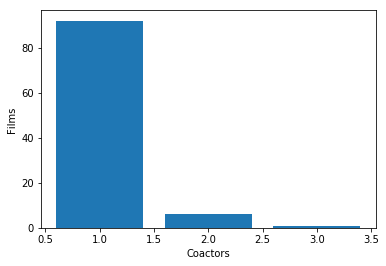

In [33]:
import matplotlib.pyplot as plt
import numpy as np
films_histogram_dic = {}
def construct_histogram_dic(films_with_coactor_item):
    number_of_films_coactored_per_actor = len(films_with_coactor_item)
    if films_histogram_dic.has_key(number_of_films_coactored_per_actor):
        films_histogram_dic[number_of_films_coactored_per_actor] = films_histogram_dic[number_of_films_coactored_per_actor] + 1
    else:
        films_histogram_dic[number_of_films_coactored_per_actor] = 1

map(construct_histogram_dic,films_with_coactor)

number_of_coactors = []
amount_of_films = []

def construct_histogram_points(item):
    number_of_coactors.append(item[0])
    amount_of_films.append(item[1])
    
map(construct_histogram_points,films_histogram_dic.items())

number_of_coactors = np.array(number_of_coactors)
amount_of_films = np.array(amount_of_films)


plt.bar(number_of_coactors,amount_of_films,align='center') # A bar chart
plt.xlabel('Coactors')
plt.ylabel('Films')

plt.show()